# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using SQLite Table to read data.
#con = sqlite3.connect('/content/database.sqlite')

# filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con)
filtered_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Reviews.csv')
filtered_data = filtered_data[:100000]
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:


#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(88463, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

88.46300000000001


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(88461, 10)


1    75313
0    13148
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
This is one of the BEST spices I have ever used- great an everything. I found it originally at Whole Foods and then used Amazon.
I have used this product in the past and was highly satisfied. It works very well. I would just caution first time users not to make the tea too strong or your results may be "too good".
These have a great smell for my dog, he loves them and they are working VERY well with "heel". They are a great size too, because we do a lot of training and the smaller the treat the better.


In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:


# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
This is one of the BEST spices I have ever used- great an everything. I found it originally at Whole Foods and then used Amazon.
I have used this product in the past and was highly satisfied. It works very well. I would just caution first time users not to make the tea too strong or your results may be "too good".
These have a great smell for my dog, he loves them and they are working VERY well with "heel". They are a great size too, because we do a lot of training and the smaller the treat the better.


In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:

sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have used this product in the past and was highly satisfied. It works very well. I would just caution first time users not to make the tea too strong or your results may be "too good".


In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [ ]:

#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have used this product in the past and was highly satisfied It works very well I would just caution first time users not to make the tea too strong or your results may be too good 


In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:



# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 88461/88461 [00:36<00:00, 2413.82it/s]


In [ ]:

preprocessed_reviews[1500]

'used product past highly satisfied works well would caution first time users not make tea strong results may good'

In [ ]:
a=int(len(preprocessed_reviews)*0.7)

In [ ]:
x_train=preprocessed_reviews[:a]
x_test=preprocessed_reviews[a:]
y_train=final['Score'][:a]
y_test=final['Score'][a:]

In [ ]:
l_words=[]
for i in tqdm(x_train):
    m=i.split()
    l_words.extend(m)
from collections import Counter
s=Counter(l_words)
a=list(s.keys())
b=list(s.values())
c=np.array(b)




100%|██████████| 61922/61922 [00:00<00:00, 273808.80it/s]


In [ ]:

top_words = 5000
d=np.argsort(c)
m={}

In [ ]:

for i in range(5000):
    m[a[d[-(i+1)]]]=i+1

In [ ]:
train_data=[]
for i in tqdm(x_train):
    j=i.split()
    q=[]
    for p in range(len(j)):
        if j[p] not in list(m.keys()):
            continue
        else:
            q.append(m[j[p]])
    train_data.append(q)



100%|██████████| 61922/61922 [03:44<00:00, 275.45it/s]


In [ ]:
test_data=[]
for i in tqdm(x_test):
    j=i.split()
    q=[]
    for p in range(len(j)):
        if j[p] not in list(m.keys()):
            continue
        else:
            q.append(m[j[p]])
    test_data.append(q)

100%|██████████| 26539/26539 [01:46<00:00, 248.55it/s]


In [ ]:
q=[]
for i in range(len(train_data)):
    q.append(len(train_data[i]))
print(max(q))


738


In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


In [ ]:
max_review_length = 800
x_train = sequence.pad_sequences(train_data, maxlen=max_review_length)
x_test = sequence.pad_sequences(test_data, maxlen=max_review_length)


In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 800, 32)           160032    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))
# Final evaluation of the model

Train on 61922 samples, validate on 26539 samples
Epoch 1/10
61922/61922 [==============================] - 1967s 32ms/step - loss: 0.2715 - acc: 0.8928 - val_loss: 0.2388 - val_acc: 0.9037
Epoch 2/10
61922/61922 [==============================] - 1743s 28ms/step - loss: 0.2090 - acc: 0.9146 - val_loss: 0.2360 - val_acc: 0.9029
Epoch 3/10
61922/61922 [==============================] - 1857s 30ms/step - loss: 0.1917 - acc: 0.9227 - val_loss: 0.2495 - val_acc: 0.8946
Epoch 4/10
61922/61922 [==============================] - 1665s 27ms/step - loss: 0.1762 - acc: 0.9297 - val_loss: 0.2425 - val_acc: 0.8972
Epoch 5/10
61922/61922 [==============================] - 1778s 29ms/step - loss: 0.1586 - acc: 0.9372 - val_loss: 0.2534 - val_acc: 0.8983
Epoch 6/10
61922/61922 [==============================] - 1747s 28ms/step - loss: 0.1425 - acc: 0.9441 - val_loss: 0.2761 - val_acc: 0.8977
Epoch 7/10
61922/61922 [==============================] - 1806s 29ms/step - loss: 0.1271 - acc: 0.9510 - val_l

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

Test score: 0.36346973257823
Test accuracy: 0.8919326274516898


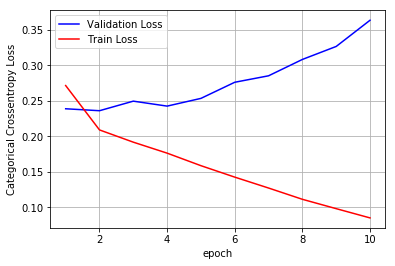

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,10+1))
vy = model.history.history['val_loss']
ty = model.history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 800, 32)           160032    
_________________________________________________________________
lstm_4 (LSTM)                (None, 800, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 243,483
Trainable params: 243,483
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x_train, y_train, nb_epoch=10, batch_size=256,validation_data=(x_test,y_test))

Train on 61922 samples, validate on 26539 samples
Epoch 1/10
61922/61922 [==============================] - 846s 14ms/step - loss: 0.3081 - acc: 0.8809 - val_loss: 0.2411 - val_acc: 0.9015
Epoch 2/10
61922/61922 [==============================] - 847s 14ms/step - loss: 0.2107 - acc: 0.9146 - val_loss: 0.2350 - val_acc: 0.9022
Epoch 3/10
61922/61922 [==============================] - 841s 14ms/step - loss: 0.1932 - acc: 0.9215 - val_loss: 0.2412 - val_acc: 0.8981
Epoch 4/10
61922/61922 [==============================] - 841s 14ms/step - loss: 0.1793 - acc: 0.9271 - val_loss: 0.2417 - val_acc: 0.8963
Epoch 5/10
61922/61922 [==============================] - 840s 14ms/step - loss: 0.1667 - acc: 0.9328 - val_loss: 0.2534 - val_acc: 0.8971
Epoch 6/10
61922/61922 [==============================] - 838s 14ms/step - loss: 0.1532 - acc: 0.9386 - val_loss: 0.2927 - val_acc: 0.8917
Epoch 7/10
61922/61922 [==============================] - 840s 14ms/step - loss: 0.1405 - acc: 0.9450 - val_loss: 0.

Test score: 0.3645038106755456
Test accuracy: 0.8825878895323118


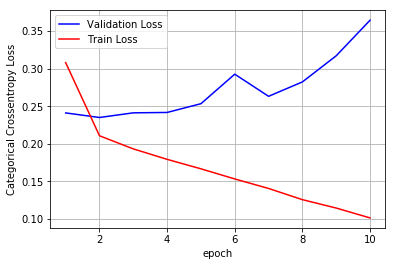

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')


x = list(range(1,10+1))
vy = model.history.history['val_loss']
ty = model.history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation accuracy")
    ax.plot(x, ty, 'r', label="Train accuracy")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

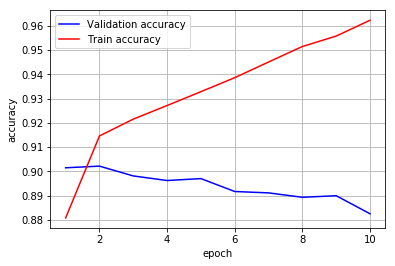

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('accuracy')


x = list(range(1,10+1))
vy = model.history.history['val_acc']
ty = model.history.history['acc']
plt_dynamic(x, vy, ty, ax)

In [ ]:
from prettytable import PrettyTable
LSTM_table = PrettyTable()
LSTM_table.field_names = ['model','accuracy','loss']
LSTM_table.add_row(['LSTM_ETWORK',87.10,0.0626])
LSTM_table.add_row(['2 LSTM_NETWORK',87.14,0.0460])
print(LSTM_table)

+----------------+----------+--------+
|     model      | accuracy |  loss  |
+----------------+----------+--------+
|  LSTM_ETWORK   |   87.1   | 0.0626 |
| 2 LSTM_NETWORK |  87.14   | 0.046  |
+----------------+----------+--------+
